$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\renewcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

In [1]:
# Uncomment the following line to install the required packages if not already installed
# !pip install qiskit qiskit-aer qiskit-ibm-runtime matplotlib pylatexenc qiskit-ibm-transpiler[ai-local-mode] mthree

# Quantum Walks and Monte Carlo

The solution is organized in five parts (matching the five project tasks):

- Part I (task 1) - two pages description of the chosen approach
- Part II (task 2) - Generalizing the Quantum Galton Board from the scientific paper to $n$ levels and obtaining normal (Gaussian) distribution in the tally bins.
- Part III (task 3) - Modifying the Quantum Galton Board to obtain Exponential and Hadamard Random Walk (bi-modal) Distributions and validating on noiseless simulator.
- Part IV (task 4) - Optimizing the circuits to execute on noisy simulators. We apply the technique allowing to load any distribution and show the results for Gaussian, Exponential and Hadamard distributions
- Part V (task 5) - Analyzing statistical distances of generated values against reference distributions. We also perform comprehensive study of circuits' depth depending on number of Galton Board levels

Appendix A showcases the runs of the optimized circuits on real IBM Torino device (the same backend was used for noise modeling).

## Part I - Universal Statistical Simulator - Approach Summary

The 2-pager description of the approach to achieve various distributions with Quantum Galton Board can be found here: [solution summary](solution_2pager.pdf).

## Part II - General Algorithm for Quantum Galton Box

In this part, we are generalizing the Quantum Galton Board approach to $n$ levels. We put the circuit code as well as simulation runs in this notebook while two helper modules we created are outside of this notebook not to clutter the code (`circuit_runner.py` and `distributions.py`). These helper module encapsulate:
- Circuit running
- Plotting sampled distributions against reference ones
- Generating distributions (normal, exponential, hadamard walk) that are used as references to compare to

Below we import the required SDK modules as well helpers that we created.

In [2]:
from typing import List, Tuple

import math
import numpy as np
from collections import defaultdict

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

import matplotlib.pyplot as plt

from circuit_runner import RunMode, run_simulation, ai_transpile_circuit
from distributions import DistributionGenerator, DistributionType

In [3]:
plt.style.use("dark_background")

Set the global parameters:
- `SHOTS` - how many shots to sample when running quantum circuit
- `ENABLE_REAL_DEVICE` - controls whether to submit the jobs to a real backend

The `results` dictionary will collect the outcomes of various runs for later analysis.

In [4]:
SHOTS = 4096
ENABLE_REAL_DEVICE = True
results = {}

`create_qdb_circuit` builds the Quantum Galton Board given the number of levels `n` and a `coin` function.

In [5]:
def calculate_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    start, finish = middle - level, middle + level
    return [(i, i + 1) for i in range(start, finish)]

def create_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        """Apply the quantum pegs operation for the Galton Board."""
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)


    def levels(qc: QuantumCircuit):
        """Apply the quantum pegs for each level of the Galton Board."""
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, calculate_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        """Final measurement of tally qubits"""
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    quantum_coin = QuantumRegister(1, "coin")
    qgb = QuantumRegister(2 * n + 1, "QGB")
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(
        quantum_coin, qgb, distribution, name="Quantum Galton Board"
    )
    levels(circuit)
    measures(circuit)
    return circuit

In [6]:
def hadamard_coin(qc: QuantumCircuit, n: int, level: int):
    """Applies a Hadamard coin operation for the Quantum Galton Board."""
    qc.h(0)

Below we show the 3 levels circuit for quantum galton board.

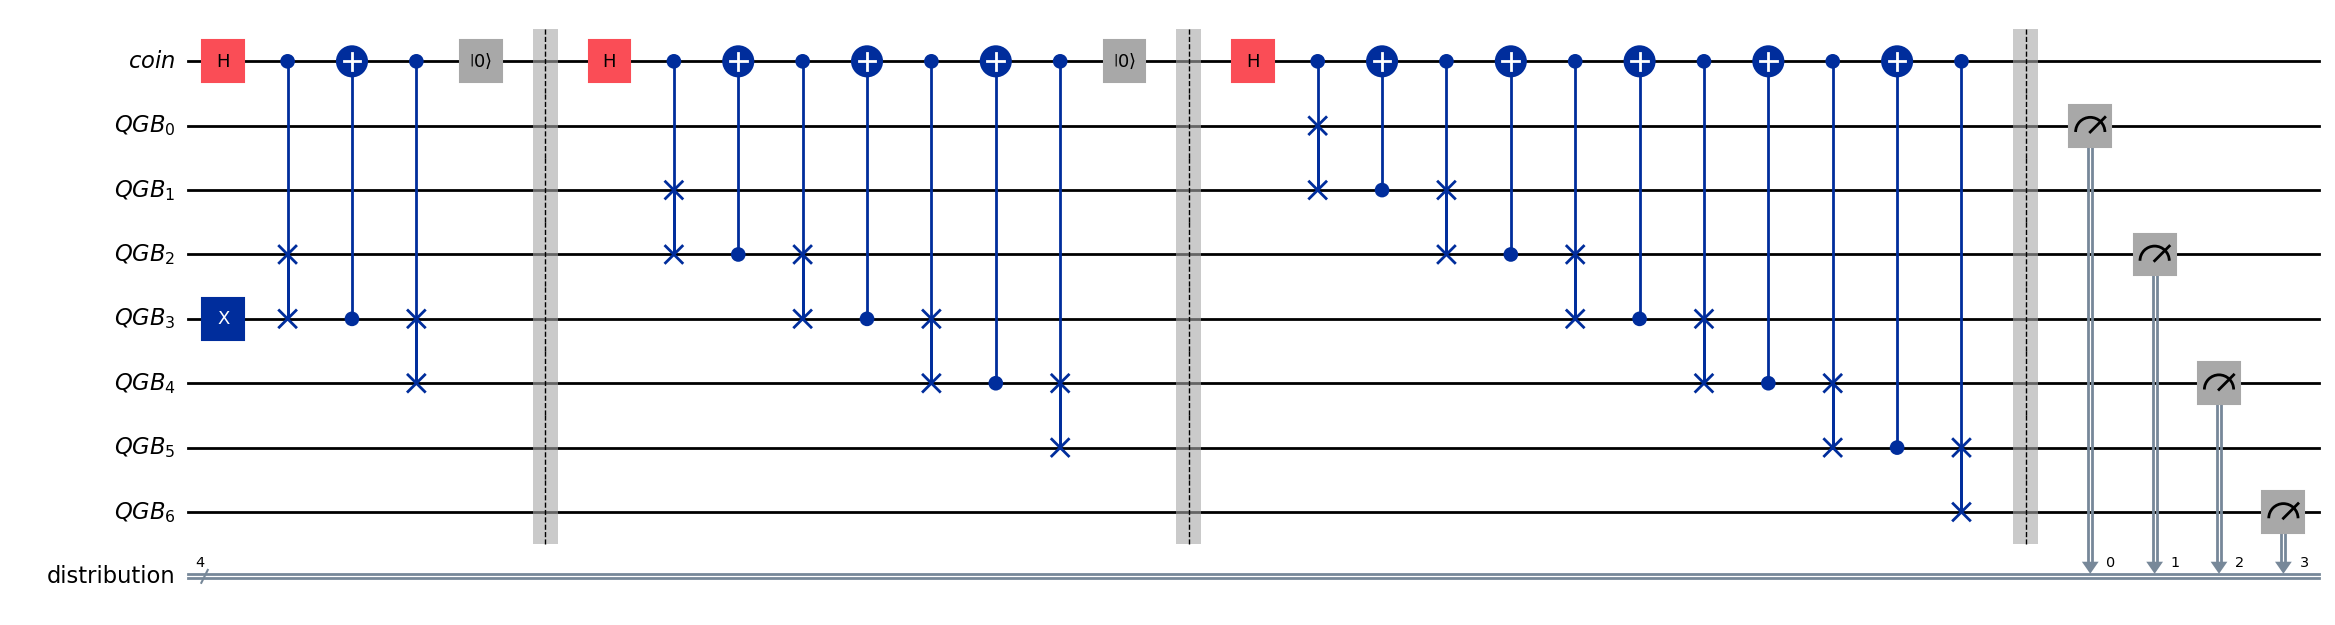

In [7]:
qc = create_qgb_circuit(3, hadamard_coin)
qc.draw("mpl", fold=-1)

In the `circuit_runner.py` helper module, we defined a function that will run the appropriate simulation of our circuit. It will leverage CircuitRunner class to execute the circuits, get the results and plot them against the reference distribution. `DistributionGenerator` class is used to calculate the perfect case of reference distributions. It supports normal, exponential, hadamard random walk and uniform distribution generation.

Width and depth of transpiled circuit: 39, 324


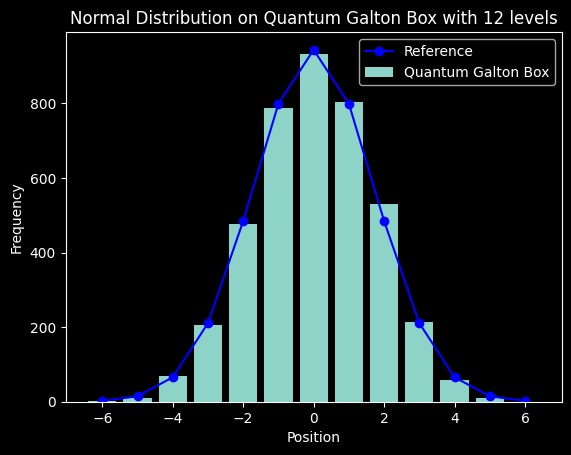

In [8]:
n = 12
results["gaussian_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    hadamard_coin,
    RunMode.NOISELESS_SIMULATOR,
    DistributionType.NORMAL,
    f"Normal Distribution on Quantum Galton Box with {n} levels",
)

We can see that noiseless simulation has a good match with the reference distribution.

Our implementation is fairly generic and allows easy introduction of custom coins that control the distribution. As an example, we could have a biased distribution with RY-rotation coin as demonstrated below.

Width and depth of transpiled circuit: 27, 152


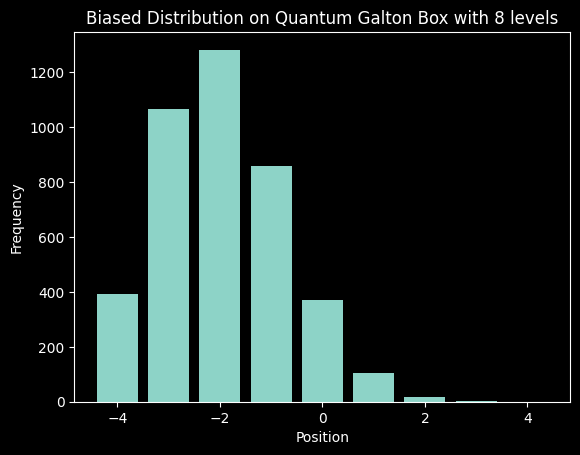

In [9]:
coin_function = lambda qc, n, level: qc.ry(2 * np.pi / 3, 0)
n = 8
_ = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    coin_function,
    RunMode.NOISELESS_SIMULATOR,
    title=f"Biased Distribution on Quantum Galton Box with {n} levels",
    show_reference=False,
)

## Part III - Modified Target Distributions

As mentioned in Part II, we are able to introduce different coins in order to modify the output distribution of our Quantum Galton Box. In this part, we will generate Exponential Distribution and Hadamard Quantum Walk.

### Exponential Distribution

Let's now create an exponential coin that modifies the righmost peg on each level. We will condition its rotation on the appropriate qubit for each level.

In [10]:
def exponential_coin(qc: QuantumCircuit, n, level):
    """Applies an exponential coin rotation based on the level."""
    theta = 2 * math.acos(np.sqrt(1 / np.e))
    if level == 1:
        qc.ry(theta, 0)
    else:
        middle = n + 1
        for i in range(middle - level + 1, middle + level - 1):
            qc.cx(i, 0)
        qc.cry(theta, middle + level - 1, 0)

Width and depth of transpiled circuit: 39, 489


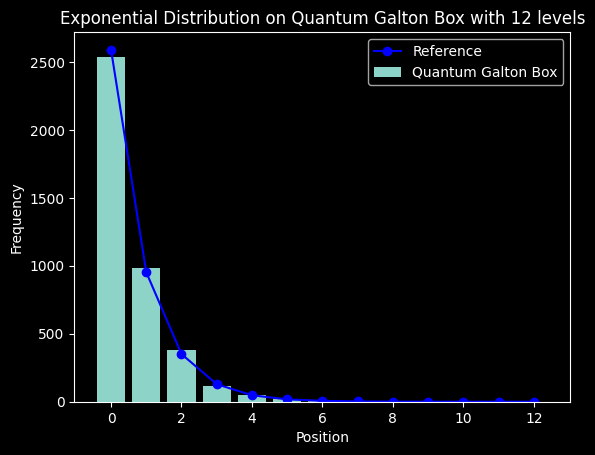

In [11]:
n = 12
results["exponential_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    exponential_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.EXPONENTIAL,
    title=f"Exponential Distribution on Quantum Galton Box with {n} levels",
)

### Hadamard Quantum Walk

We modify the QGB circuit to simultaneously shift the ball left and right (controlled by the coin state). It removes the need to apply CNOT between the controlled-SWAP operations, but we now have to control it both on 0 and 1 values of the coin.

In [12]:
def calculate_hrw_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    middle = n + 1
    return [(i, i + 1) for i in range(middle - level, middle + level)]


def calculate_hrw_fs_wire_tuples(n) -> List[Tuple[int, int]]:
    iterations = math.floor((n + 1) / 2)
    return [(i * 2 + 1, 2 * n + 2 - (i * 2) - 1) for i in range(iterations)]


def create_hrw_qgb_circuit(n, coin) -> QuantumCircuit:
    """Creates a quantum circuit for the n-steps Hadamard Walk distribution
    leveraging the Quantum Galton Board (QGB) with n levels."""

    def qpegs(qc: QuantumCircuit, wire_tuples):
        control_value = 0
        for wires in wire_tuples:
            qc.cswap(0, wires[0], wires[1], ctrl_state=control_value)
            control_value ^= 1

    def levels(qc: QuantumCircuit):
        qc.x(n + 1)
        for level in range(1, n + 1):
            coin(qc, n, level)
            qpegs(qc, calculate_hrw_wire_tuples(n, level))
            qc.barrier()

    def final_swap(qc: QuantumCircuit):
        qc.reset(0)
        qc.h(0)
        for wires in calculate_hrw_fs_wire_tuples(n):
            qc.cswap(0, wires[0], wires[1])
        qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(range(1, 2 * n + 2, 2)):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(2 * n + 2)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    final_swap(circuit)
    measures(circuit)
    return circuit

Notice that the Hadamard circuit doesn't reset the coin qubit after each level to keep the interference going. We do reset it after the last level to apply the swap with probability 0.5 in order to obtain symmetric distribution of Hadamard Random Walk. See circuit drawing below.

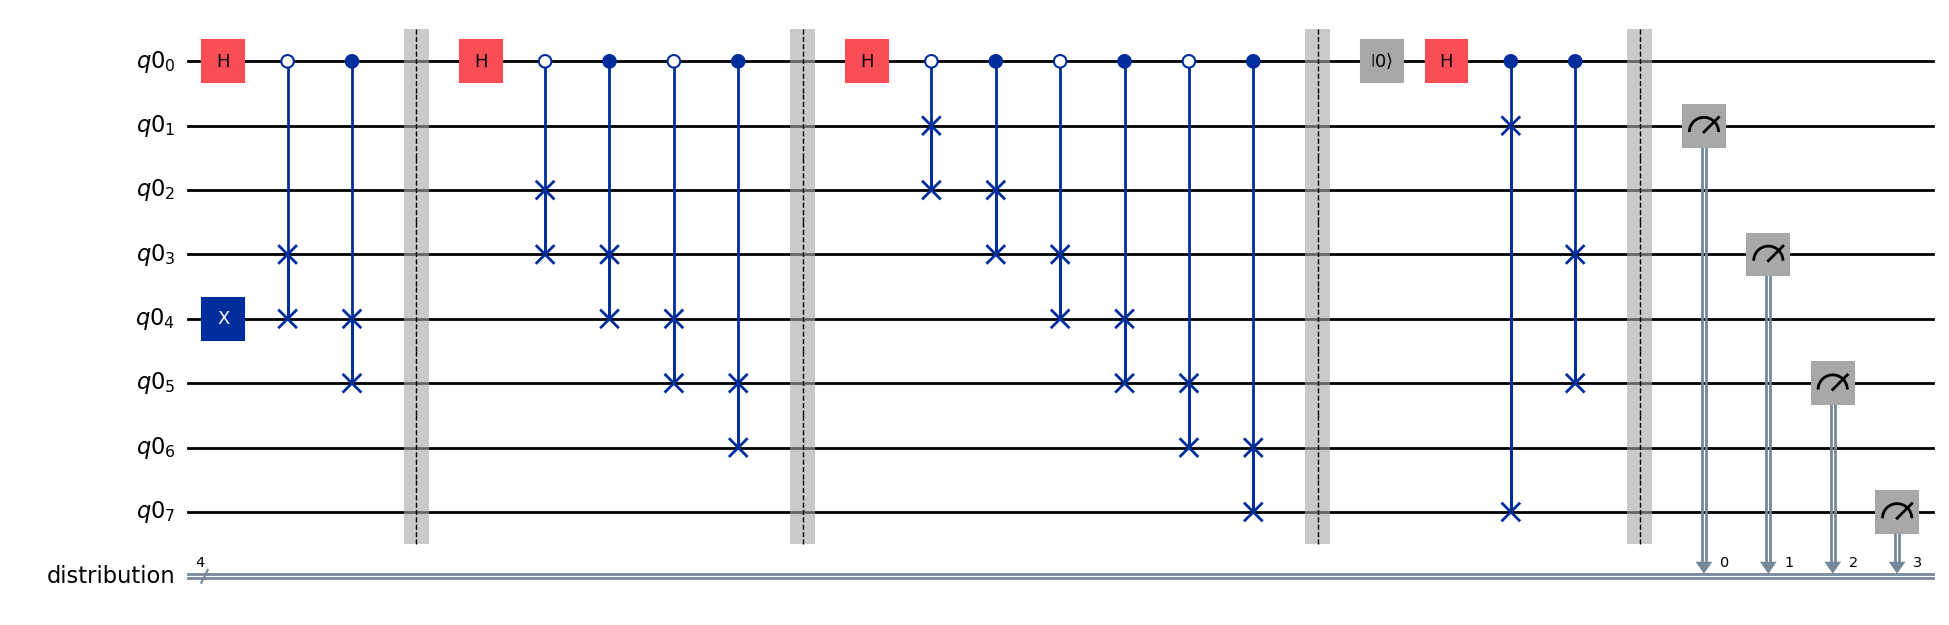

In [13]:
circuit = create_hrw_qgb_circuit(3, hadamard_coin)
circuit.draw("mpl", fold=-1)

Width and depth of transpiled circuit: 39, 321


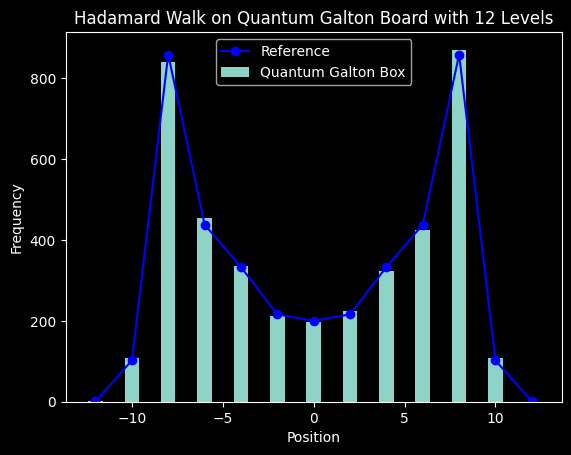

In [14]:
n = 12
results["hadamard_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_hrw_qgb_circuit,
    hadamard_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.HADAMARD,
    title=f"Hadamard Walk on Quantum Galton Board with {n} Levels",
)

## Part IV - Optimization under Noise Models

Having our implementation working on the noiseless simulators, we will now work on exploring the circuit under a noise model.

In [15]:
service = QiskitRuntimeService()
real_torino = service.backend("ibm_torino")
real_brisbane = service.backend("ibm_brisbane")
least_busy_backend = service.least_busy()
print(f"torino qubits: {real_torino.num_qubits}, brisbane qubits: {real_brisbane.num_qubits}")
print(f"least busy backend: {least_busy_backend.name}, qubits: {least_busy_backend.num_qubits}")

qiskit_runtime_service._resolve_cloud_instances:WARNING:2025-08-07 14:56:03,842: Default instance not set. Searching all available instances.


torino qubits: 133, brisbane qubits: 127
least busy backend: ibm_brisbane, qubits: 127


After careful observations of the Galton board properties, it is possible to create a universal distribution simulator and optimize the use of qubits. The naive implementation requires $2n+2$ qubits. We can load any distribution using only $n+3$ qubits. It is worth noting that Galton board produced a superposition of all states with Hamming Weight 1 (single qubit is 1 and the rest are 0). There are $n+1$ such states (as number of tally bin qubits); hence, the probabilities vector size is also $n+1$. For example, in case of 2 levels Galton board, we have 3 tally bin qubits and the resulting state will be:

$\alpha\ket{001} + \beta\ket{010} + \gamma\ket{100}$


In a more general case, we can write it as:

$\ket{\psi} = \sum_{i=0}^{n}{\sqrt{p(i)}\ket{2^i}}_{n+1}$

$\sum_{i=0}^{n}{p(i)} = 1$

$\forall i\:\:p(i) >= 0$

Given the vector of $n+1$ probabilities, we can build an optimized coin function and a quantum circuit to assure the ball reaches each tally bin with the desired probability (implementation below).

The calculation of rotation angle for level $i$ is as follows:

$\theta_i = 2arccos(\sqrt{1-\frac{p_i}{\sum_{j=i}^{n+1}{p_j}}})$


In [16]:
def optimized_coin(qc: QuantumCircuit, n, level, probs: np.ndarray):
    """Applies the required coin rotation based on the level."""
    if level == 1:
        prob = probs[0]
        theta = 2 * math.acos(np.sqrt(1-prob))
        qc.ry(theta, 0)
    else:
        prob = probs[level - 1] / probs[(level-1):].sum()
        theta = 2 * math.acos(np.sqrt(1-prob))
        qc.cry(theta, level + 1, 0)

def calculate_opt_wire_tuples(n, level) -> List[Tuple[int, int]]:
    if level < 1 or level > n:
        raise ValueError("Level must be between 1 and n (inclusive).")
    return [(i, i + 1) for i in range(level, level + 2)]


def create_opt_qgb_circuit(n, coin, probs: list | np.ndarray) -> QuantumCircuit:
    """Creates an optimized quantum circuit for the Quantum Galton Board (QGB) with n levels."""

    if isinstance(probs, list):
        my_probs  = np.array(probs)
    else:
        my_probs = probs
    def qpegs(qc: QuantumCircuit, wire_tuples: List[Tuple[int]]):
        for i, wires in enumerate(wire_tuples):
            qc.cswap(0, wires[0], wires[1])
            if i < len(wire_tuples) - 1:
                qc.cx(wires[1], 0)

    def levels(qc: QuantumCircuit):
        qc.x(2)
        for level in range(1, n + 1):
            coin(qc, n, level, my_probs)
            qpegs(qc, wire_tuples=calculate_opt_wire_tuples(n, level))
            if level < n:
                qc.reset(0)
            qc.barrier()

    def measures(qc: QuantumCircuit):
        for cbit, qbit in enumerate(list(range(1, n + 1)) + [n + 2]):
            qc.measure(qbit, cbit)

    qr = QuantumRegister(n + 3)
    distribution = ClassicalRegister(n + 1, "distribution")
    circuit = QuantumCircuit(qr, distribution)
    levels(circuit)
    measures(circuit)
    return circuit

The circuit is now more compact and the number of required CSWAP gates is significantly reduced. Let's draw the 4-level circuit with some arbitrary probability distribution vector.

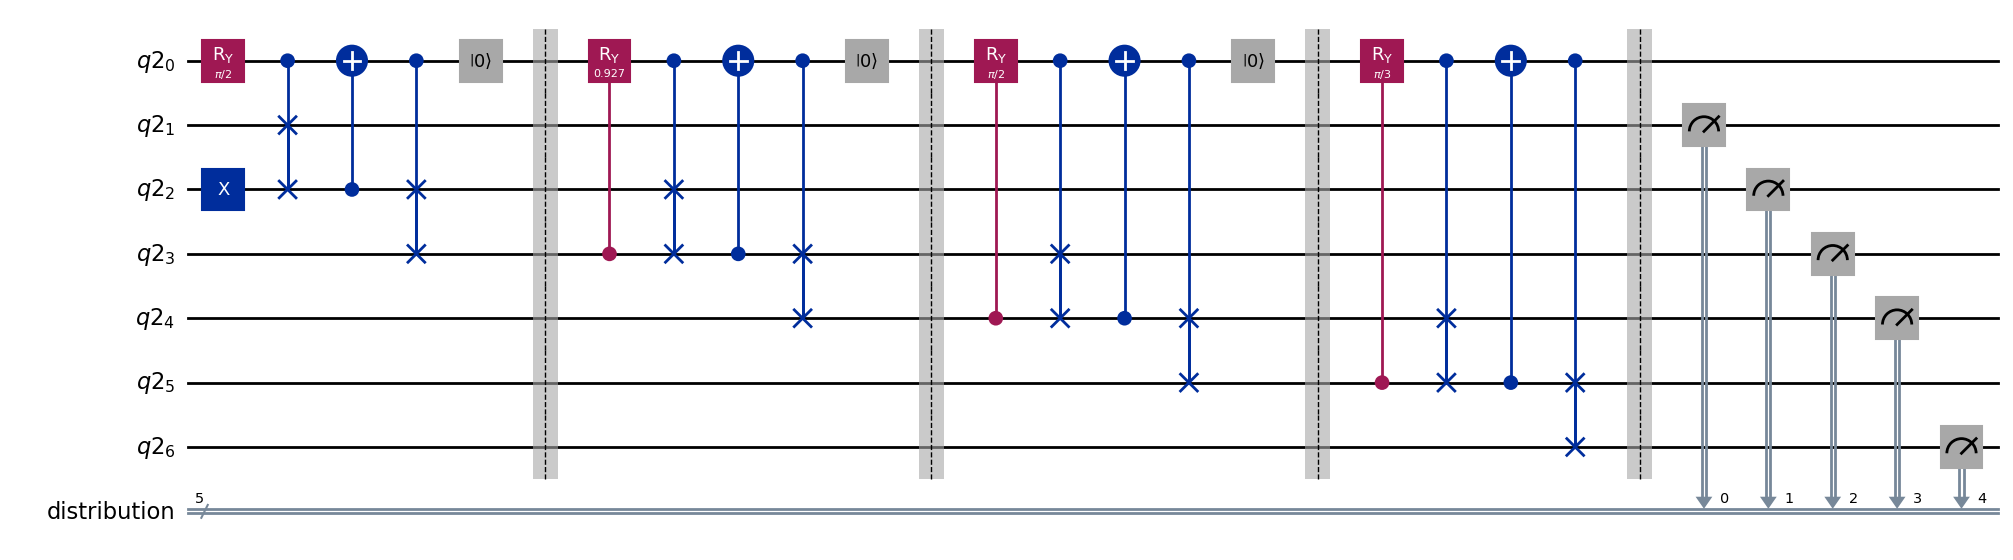

In [17]:
circuit = create_opt_qgb_circuit(4, optimized_coin, [0.5, 0.1, 0.2, 0.05, 0.15])
circuit.draw("mpl", fold=-1)

First, we will run the original circuits (without optimizations) on a noisy simulator and display the results against reference distributions for visual examination. Then, we will switch to optimized circuits and run them under various noise conditions (with / without / on real device).

Width and depth of transpiled circuit: 138, 1149
Width and depth after AI Pass: 138, 840


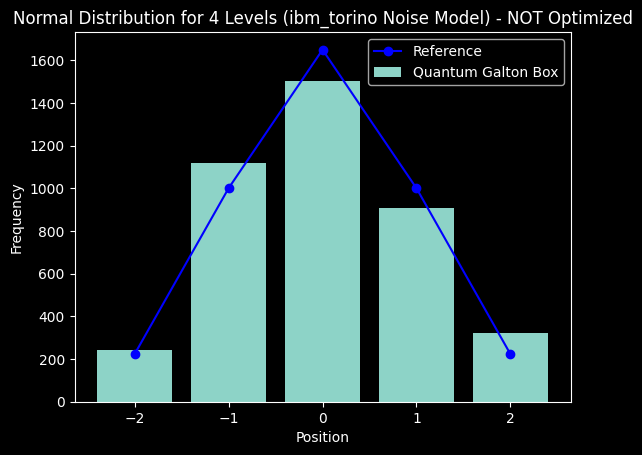

Width and depth of transpiled circuit: 138, 1248
Width and depth after AI Pass: 138, 955


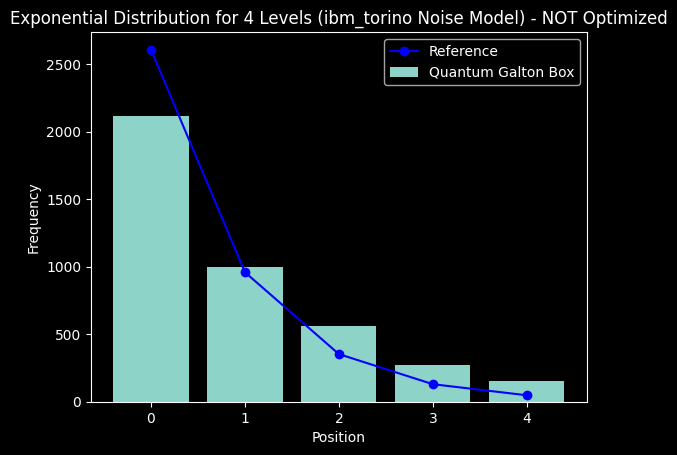

Width and depth of transpiled circuit: 138, 1194
Width and depth after AI Pass: 138, 946


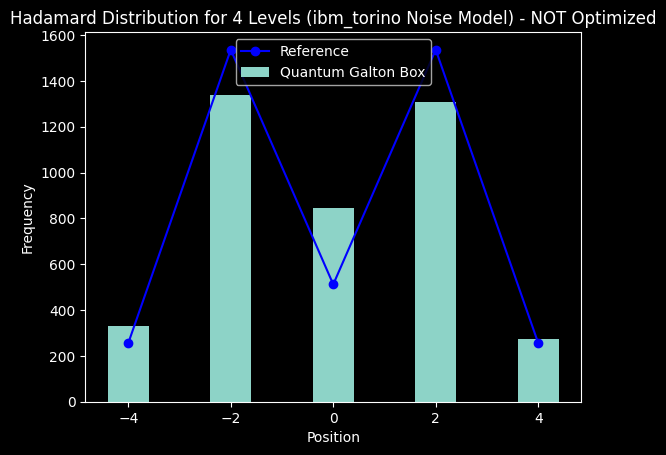

In [18]:
n = 4
_ = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    hadamard_coin,
    RunMode.NOISY_SIMULATOR,
    distribution_type=DistributionType.NORMAL,
    title=f"Normal Distribution for {n} Levels ({real_torino.name} Noise Model) - NOT Optimized",
    backend=real_torino,
)
_ = run_simulation(
    n,
    SHOTS,
    create_qgb_circuit,
    exponential_coin,
    RunMode.NOISY_SIMULATOR,
    distribution_type=DistributionType.EXPONENTIAL,
    title=f"Exponential Distribution for {n} Levels ({real_torino.name} Noise Model) - NOT Optimized",
    backend=real_torino,
)
_ = run_simulation(
    n,
    SHOTS,
    create_hrw_qgb_circuit,
    hadamard_coin,
    RunMode.NOISY_SIMULATOR,
    distribution_type=DistributionType.HADAMARD,
    title=f"Hadamard Distribution for {n} Levels ({real_torino.name} Noise Model) - NOT Optimized",
    backend=real_torino,
)

For just 4 levels, we are getting fairly deep (>800 or even >900) circuits and quite large deviations from the reference distribution. We provide more circuits depth analysis in Part V.

Let's now apply the optimized circuit approach to the three distributions we are studying: Gaussian, Exponential and Hadamard Random Walk.

We will run all the distribution generations under the following three simulations:
- Noiseless AER simulator
- Noisy Simulator with noise model from the `ibm_torino` QPU backend
- Real device (IBM Torino) with and without M3 noise mitigation

We set the $n$ levels for all simulations to be equal to assure we are generating the distribution vectors of the same size.

In [19]:
n = 8
dg = DistributionGenerator(n, SHOTS)

### Gaussian Distribution

Below, we generate the Gaussian probabilities and execute the simulations of optimized circuit and store the results for further comparison.


Width and depth of transpiled circuit: 20, 61


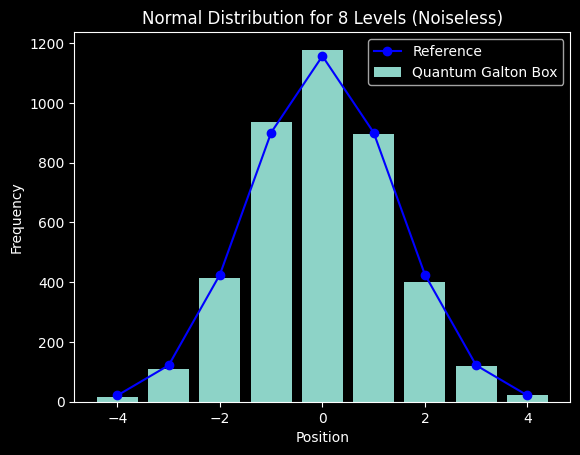

Width and depth of transpiled circuit: 142, 932
Width and depth after AI Pass: 142, 678


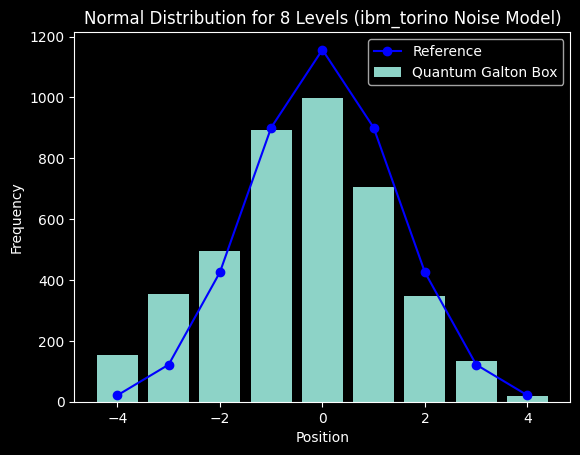

In [20]:
gaussian = dg.normal(generate_probs=True)[1]
results["gaussian_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISELESS_SIMULATOR,
    title=f"Normal Distribution for {n} Levels (Noiseless)",
    probs=gaussian,
)
results["gaussian_noisy"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISY_SIMULATOR,
    title=f"Normal Distribution for {n} Levels ({real_torino.name} Noise Model)",
    backend=real_torino,
    probs=gaussian,
)

### Exponential Distribution

We will apply the same procedure of collecting results for the exponential distribution leveraging the optimized circuit design.

Width and depth of transpiled circuit: 20, 61


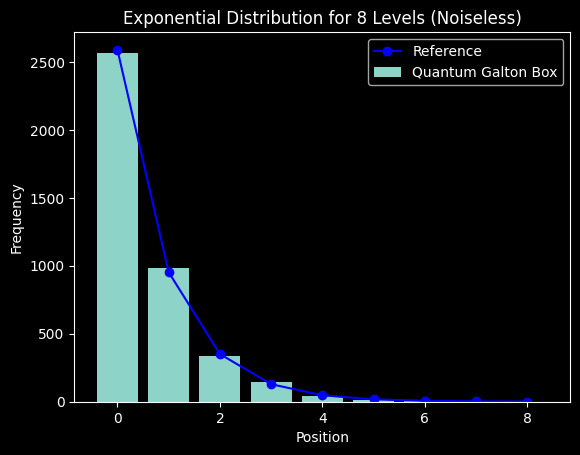

Width and depth of transpiled circuit: 142, 933
Width and depth after AI Pass: 142, 698


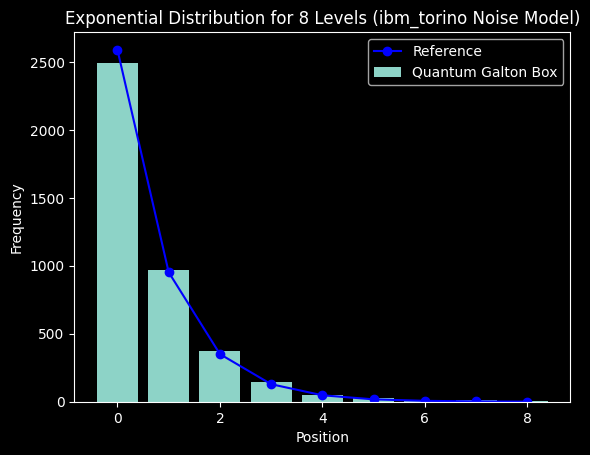

In [21]:
exponential = dg.exponential(generate_probs=True)[1]
results["exponential_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.EXPONENTIAL,
    title=f"Exponential Distribution for {n} Levels (Noiseless)",
    probs=exponential,
)
results["exponential_noisy"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISY_SIMULATOR,
    distribution_type=DistributionType.EXPONENTIAL,
    title=f"Exponential Distribution for {n} Levels ({real_torino.name} Noise Model)",
    backend=real_torino,
    probs=exponential,
)

> NOTE: There is a well-known implementation of Exponential distribution generation on $n$ qubits with $n$ `RY` rotations. This is the most optimal way of generating this specific distribution with only single qubit gates. The implementation is taken from the Classiq SDK. Showing it here just for the completeness.

In [22]:
# Classiq implementation
# repeat(q.len, lambda i: RY(2.0 * atan(exp((-rate * 2.0**i) / 2.0)), q[i]))
def prep_exponential(n, rate) -> QuantumCircuit:
    """Prepare exponential distribution on n qubits."""
    circuit = QuantumCircuit(n, n)
    for i in range(n):
        circuit.ry(2.0 * math.atan(math.exp((-rate * 2.0**i))), i)
    circuit.measure(range(n), range(n))
    return circuit

### Hadamard Random Walk Distribution

Width and depth of transpiled circuit: 20, 61


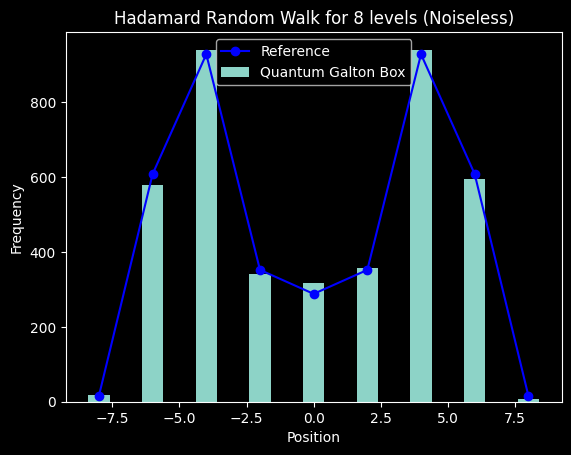

Width and depth of transpiled circuit: 142, 932
Width and depth after AI Pass: 142, 681


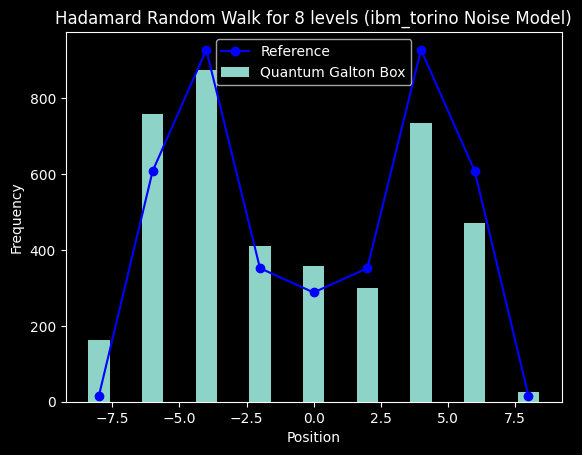

In [23]:
hadamard_probs = dg.hadamard(generate_probs=True)[1]
results["hadamard_noiseless"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISELESS_SIMULATOR,
    distribution_type=DistributionType.HADAMARD,
    title=f"Hadamard Random Walk for {n} levels (Noiseless)",
    probs=hadamard_probs,
)
results["hadamard_noisy"] = run_simulation(
    n,
    SHOTS,
    create_opt_qgb_circuit,
    optimized_coin,
    RunMode.NOISY_SIMULATOR,
    distribution_type=DistributionType.HADAMARD,
    title=f"Hadamard Random Walk for {n} levels ({real_torino.name} Noise Model)",
    backend=real_torino,
    probs=hadamard_probs,
)

## Part V - Study the Distances between Obtained and Target Distributions

Let's now turn to understanding how well the obtained distributions are approximating the target distributions.

We have collected a hefty amount of samples for both Exponential and Hadamard Random Walk circuits executed under the noise model.

In [24]:
from scipy.stats import wasserstein_distance

Here we calculate the Wasserstein and MSE distances for all the collected results.

In [25]:
wasserstein_distances = {}
for sim_name, (positions, freqs, _, ref_freqs) in results.items():
    quantum_freqs = np.array(list(freqs.values()))
    reference_freqs = np.array(ref_freqs)
    positions = np.array(positions)

    quantum_probs = quantum_freqs / quantum_freqs.sum()
    reference_probs = reference_freqs / reference_freqs.sum()
    distance = wasserstein_distance(
        u_values=positions,
        v_values=positions,
        u_weights=quantum_probs,
        v_weights=reference_probs,
    )
    tokens = sim_name.split("_")
    for i, t in enumerate(tokens):
        tokens[i] = t[0].upper() + t[1:]
    sim_name_printable = " ".join(tokens)
    print(f"Wasserstein Distance for {sim_name_printable:<40} {distance:.4f}")
    wasserstein_distances[sim_name] = distance

mse_distances = {}
for sim_name, (positions, freqs, _, ref_freqs) in results.items():
    quantum_freqs = np.array(list(freqs.values()))
    reference_freqs = np.array(ref_freqs)
    positions = np.array(positions)
    quantum_probs = quantum_freqs / quantum_freqs.sum()
    reference_probs = reference_freqs / reference_freqs.sum()

    mse_value = np.mean((quantum_probs - reference_probs) ** 2) * SHOTS
    metric_name = "MSE"

    # Format and output
    tokens = [t[0].upper() + t[1:] for t in sim_name.split("_")]
    sim_name_printable = " ".join(tokens)
    print(f"{metric_name} for {sim_name_printable:<40} {mse_value:.6f}")
    mse_distances[sim_name] = mse_value

Wasserstein Distance for Gaussian Noiseless                       0.0282
Wasserstein Distance for Exponential Noiseless                    0.0139
Wasserstein Distance for Hadamard Noiseless                       0.0547
Wasserstein Distance for Gaussian Noisy                           0.4130
Wasserstein Distance for Exponential Noisy                        0.0845
Wasserstein Distance for Hadamard Noisy                           0.8908
MSE for Gaussian Noiseless                       0.070832
MSE for Exponential Noiseless                    0.065312
MSE for Hadamard Noiseless                       0.062934
MSE for Gaussian Noisy                           3.933430
MSE for Exponential Noisy                        0.291457
MSE for Hadamard Noisy                           3.118307


Now, let's plot the heatmap for those distances.

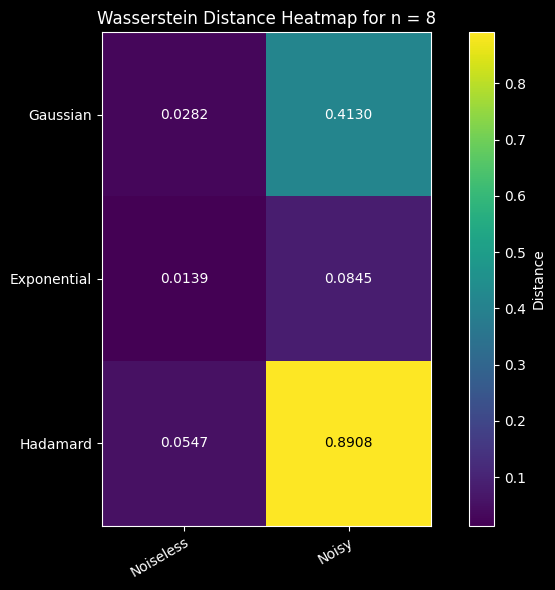

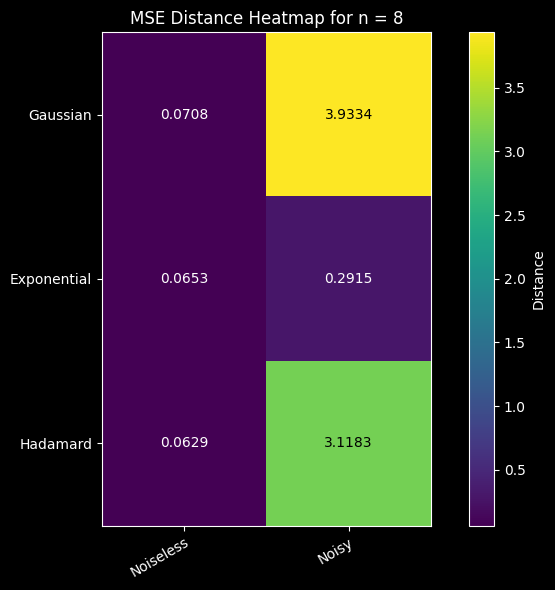

In [26]:
def plot_heatmap(distances, name=""):
    heat_map_distances = np.array(
        [
            [
                distances["gaussian_noiseless"],
                distances["gaussian_noisy"],
            ],
            [
                distances["exponential_noiseless"],
                distances["exponential_noisy"],
            ],
            [
                distances["hadamard_noiseless"],
                distances["hadamard_noisy"],
            ],
        ]
    )
    y_labels = ["Gaussian", "Exponential", "Hadamard"]
    x_labels = ["Noiseless", "Noisy"]

    fig, ax = plt.subplots(figsize=(8, 6))
    cax = ax.imshow(heat_map_distances, cmap="viridis")
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right", rotation_mode="anchor")

    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            ax.text(
                j,
                i,
                f"{heat_map_distances[i, j]:.4f}",
                ha="center",
                va="center",
                color="white" if heat_map_distances[i, j] < 0.5 else "black",
            )

    fig.colorbar(cax, label="Distance")
    ax.set_title(f"{name} Distance Heatmap for n = {n}")
    plt.tight_layout()
    plt.show()


plot_heatmap(wasserstein_distances, "Wasserstein")
plot_heatmap(mse_distances, "MSE")

Hadamard distribution is the worst performing based on Wasserstein while Gaussian came up last according to MSE.

We would also like to study how noise affects accuracy of the circuits depending on the number of levels of Quantum Galton Board. We will run the simulations for each distribution in the following configuration:
- on the noisy Aer simulator (ibm_torino noise model)
- without M3 noise mitigation
- ranging from 5 to 14 levels

Width and depth of transpiled circuit: 139, 578
Width and depth after AI Pass: 139, 423
Width and depth of transpiled circuit: 139, 582
Width and depth after AI Pass: 139, 438
Width and depth of transpiled circuit: 139, 578
Width and depth after AI Pass: 139, 426
Width and depth of transpiled circuit: 140, 696
Width and depth after AI Pass: 140, 511
Width and depth of transpiled circuit: 140, 700
Width and depth after AI Pass: 140, 528
Width and depth of transpiled circuit: 140, 700
Width and depth after AI Pass: 140, 528
Width and depth of transpiled circuit: 141, 814
Width and depth after AI Pass: 141, 615
Width and depth of transpiled circuit: 141, 814
Width and depth after AI Pass: 141, 615
Width and depth of transpiled circuit: 141, 823
Width and depth after AI Pass: 141, 609
Width and depth of transpiled circuit: 142, 932
Width and depth after AI Pass: 142, 678
Width and depth of transpiled circuit: 142, 932
Width and depth after AI Pass: 142, 678
Width and depth of transpiled ci

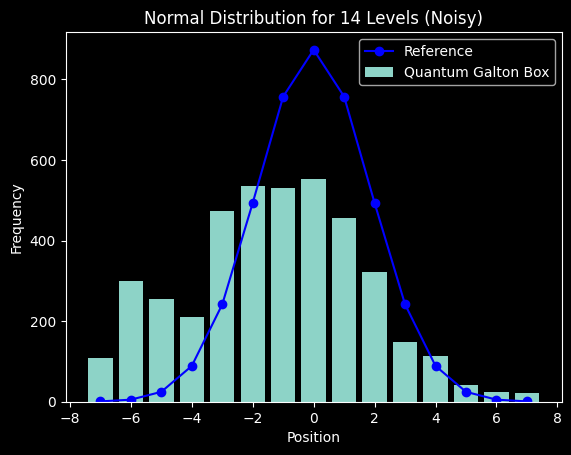

Width and depth of transpiled circuit: 148, 1640
Width and depth after AI Pass: 148, 1186


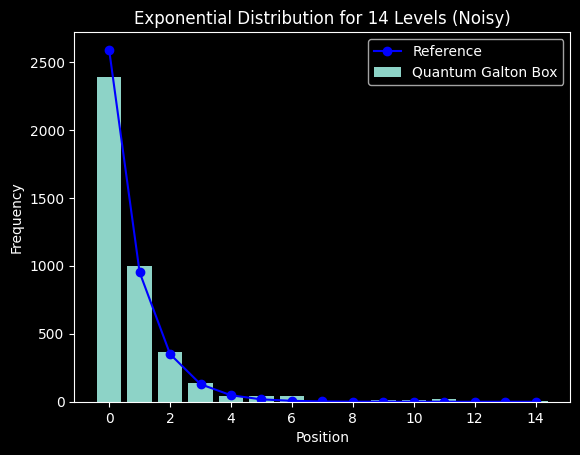

Width and depth of transpiled circuit: 148, 1640
Width and depth after AI Pass: 148, 1189


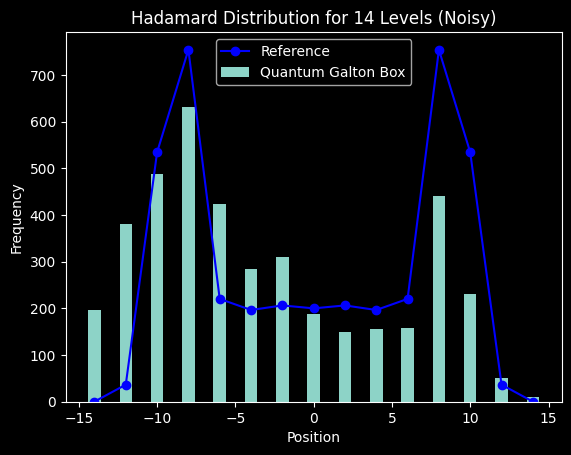

In [27]:
gaussian_noisy_results = defaultdict(int)
exponential_noisy_results = defaultdict(int)
hadamard_noisy_results = defaultdict(int)
for levels in range(5, 15):
    dg = DistributionGenerator(levels, SHOTS)
    gaussian = dg.normal(generate_probs=True)[1]
    exponential = dg.exponential(generate_probs=True)[1]
    hadamard_probs = dg.hadamard(generate_probs=True)[1]
    gaussian_noisy_results[levels] = run_simulation(
        levels,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.NOISY_SIMULATOR,
        title=f"Normal Distribution for {levels} Levels (Noisy)",
        backend=real_torino,
        mitigate_noise=False,
        distribution_type=DistributionType.NORMAL,
        probs=gaussian,
        plots=levels == 14,  # Only plot for the last level
    )
    exponential_noisy_results[levels] = run_simulation(
        levels,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.NOISY_SIMULATOR,
        title=f"Exponential Distribution for {levels} Levels (Noisy)",
        backend=real_torino,
        mitigate_noise=False,
        distribution_type=DistributionType.EXPONENTIAL,
        probs=exponential,
        plots=levels == 14,  # Only plot for the last level
    )
    hadamard_noisy_results[levels] = run_simulation(
        levels,
        SHOTS,
        create_opt_qgb_circuit,
        optimized_coin,
        RunMode.NOISY_SIMULATOR,
        title=f"Hadamard Distribution for {levels} Levels (Noisy)",
        backend=real_torino,
        mitigate_noise=False,
        distribution_type=DistributionType.HADAMARD,
        probs=hadamard_probs,
        plots=levels == 14,  # Only plot for the last level
    )

Even for the 14 levels, while we can clearly observe the deviation from the reference distributions, we still see the resemblance of Gaussian and Hadamard Random Walk. Exponential circuit maintains a really good match to the true distribution.

In [28]:
def calculate_distance(positions, freqs, reference_freqs):
    """Calculates the MSE distance between two probability distributions."""
    quantum_freqs = np.array(list(freqs.values()))
    reference_freqs = np.array(ref_freqs)
    positions = np.array(positions)
    quantum_probs = quantum_freqs / quantum_freqs.sum()
    reference_probs = reference_freqs / reference_freqs.sum()

    mse_value = np.mean((quantum_probs - reference_probs) ** 2) * SHOTS
    return mse_value

In [29]:
gaussian_distances = defaultdict(int)
exponential_distances = defaultdict(int)
hadamard_distances = defaultdict(int)
for levels, (positions, freqs, _, ref_freqs) in gaussian_noisy_results.items():
    gaussian_distances[levels] = calculate_distance(positions, freqs, ref_freqs)

for levels, (positions, freqs, _, ref_freqs) in exponential_noisy_results.items():
    exponential_distances[levels] = calculate_distance(positions, freqs, ref_freqs)

for levels, (positions, freqs, _, ref_freqs) in hadamard_noisy_results.items():
    hadamard_distances[levels] = calculate_distance(positions, freqs, ref_freqs)

We are now ready to plot the MSE distances of each distribution and their dependence on number of levels.

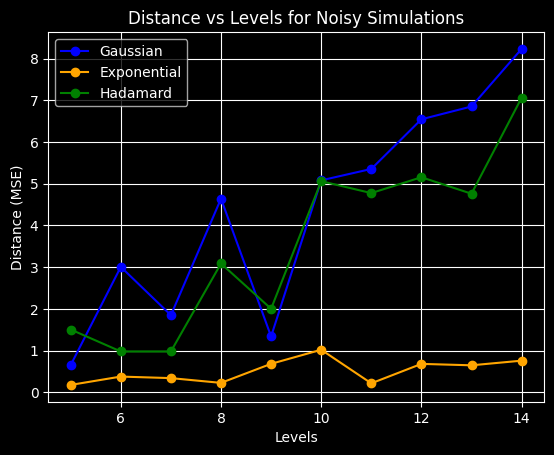

In [30]:
plt.plot(
    list(gaussian_distances.keys()),
    list(gaussian_distances.values()),
    label="Gaussian",
    marker="o",
    color="blue",
)

plt.plot(
    list(exponential_distances.keys()),
    list(exponential_distances.values()),
    label="Exponential",
    marker="o",
    color="orange",
)

plt.plot(
    list(hadamard_distances.keys()),
    list(hadamard_distances.values()),
    label="Hadamard",
    marker="o",
    color="green",
)
plt.xlabel("Levels")
plt.ylabel("Distance (MSE)")
plt.title("Distance vs Levels for Noisy Simulations")
plt.legend()
plt.grid()
plt.show()

We conclude that Exponential distribution realized the most potential from the Galton Board optimizations in terms of accuracy as shown in the graph above. Reducing the number of required qubits from $2n+2$ to $n+3$ and significantly lowering the depth of the circuit helped maintaining close enough distance from the reference values for all distribution in the presence of noise and even on a real device.

### Depth Study

Below we show how number of levels of Galton Board affect the depth of the circuit.

Calculated for 2 levels (optimized): 166
Calculated for 2 levels (NOT optimized): 257
Calculated for 3 levels (optimized): 250
Calculated for 3 levels (NOT optimized): 488
Calculated for 4 levels (optimized): 343
Calculated for 4 levels (NOT optimized): 843
Calculated for 5 levels (optimized): 423
Calculated for 5 levels (NOT optimized): 1265
Calculated for 6 levels (optimized): 511
Calculated for 6 levels (NOT optimized): 1816
Calculated for 7 levels (optimized): 615
Calculated for 7 levels (NOT optimized): 2353
Calculated for 8 levels (optimized): 678
Calculated for 8 levels (NOT optimized): 3251
Calculated for 9 levels (optimized): 783
Calculated for 9 levels (NOT optimized): 3867
Calculated for 10 levels (optimized): 851
Calculated for 10 levels (NOT optimized): 4708
Calculated for 11 levels (optimized): 939
Calculated for 11 levels (NOT optimized): 5604


Text(0.5, 1.0, 'Circuit Depth (Optimized vs Not Optimized)')

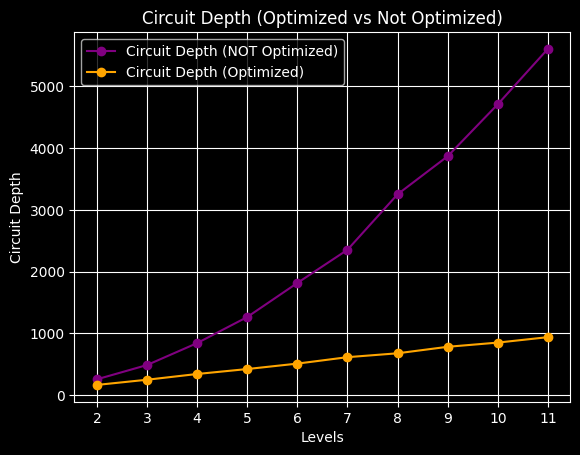

In [31]:
depths_by_levels_notopt = {}
depths_by_levels_opt = {}
for levels in range(2, 12):
    dg = DistributionGenerator(levels, SHOTS)
    gaussian = dg.normal(generate_probs=True)[1]
    circuit = create_opt_qgb_circuit(levels, optimized_coin, gaussian)
    transpiled_circuit = ai_transpile_circuit(
        circuit,
        backend=real_torino,
    )
    depths_by_levels_opt[levels] = transpiled_circuit.depth()
    print(f"Calculated for {levels} levels (optimized): {transpiled_circuit.depth()}")

    circuit = create_qgb_circuit(levels, hadamard_coin)
    transpiled_circuit = ai_transpile_circuit(
        circuit,
        backend=real_torino,
    )
    depths_by_levels_notopt[levels] = transpiled_circuit.depth()
    print(f"Calculated for {levels} levels (NOT optimized): {transpiled_circuit.depth()}")

plt.plot(
    list(depths_by_levels_notopt.keys()),
    list(depths_by_levels_notopt.values()),
    label="Circuit Depth (NOT Optimized)",
    marker="o",
    color="purple",
)
plt.plot(
    list(depths_by_levels_opt.keys()),
    list(depths_by_levels_opt.values()),
    label="Circuit Depth (Optimized)",
    marker="o",
    color="orange",
)
plt.legend()
plt.grid()
plt.xticks(list(depths_by_levels_opt.keys()))
plt.xlabel("Levels")
plt.ylabel("Circuit Depth")
plt.title("Circuit Depth (Optimized vs Not Optimized)")

We can clearly observe pure linear growth of the transpiled circuit depth as we add more levels for optimally constructed circuits while the non-optimized circuits depths has much faster growth.

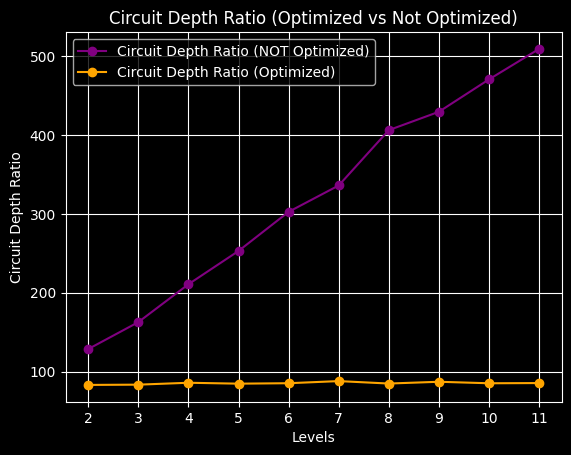

In [32]:
ratios_opt = defaultdict(float)
ratios_notopt = defaultdict(float)

for levels, depth in depths_by_levels_opt.items():
    ratio = depth / levels
    ratios_opt[levels] = ratio

for levels, depth in depths_by_levels_notopt.items():
    ratio = depth / levels
    ratios_notopt[levels] = ratio
plt.plot(
    list(ratios_notopt.keys()),
    list(ratios_notopt.values()),
    label="Circuit Depth Ratio (NOT Optimized)",
    marker="o",
    color="purple",
)
plt.plot(
    list(ratios_opt.keys()),
    list(ratios_opt.values()),
    label="Circuit Depth Ratio (Optimized)",
    marker="o",
    color="orange",
)
plt.legend()
plt.grid()
plt.xticks(list(ratios_opt.keys()))
plt.xlabel("Levels")
plt.ylabel("Circuit Depth Ratio")
plt.title("Circuit Depth Ratio (Optimized vs Not Optimized)")
plt.show()

For the optimized circuit, we see constant $\frac{depth}{levels}$ ratio, which confirms linear dependency. For the not-optimized circuits, we observe linear growth of the ratio suggesting quadratic dependency on number of levels.

## Conclusions

We have demonstrated a universal distribution simulator producing super-position over sparse set of states with Hamming Weight 1. The Galton board approach, with a few optimizations, shows promising results even on the NISQ devices as evidenced from the runs on real IBM backend `ibm_torino`.

Our approach to circuit design has resulted in a significant reduction of required qubits (from $2n+2$ to $n+3$).

The MSE distance remained below 5 for most of the levels, which is another indication of relative accuracy of the model under noisy conditions.

The linear growth of circuit depth assures efficient use of quantum resources and better resilience to noise.

## Appendix A - Running on Real Device

The optimized circuit can also be executed for all distributions we strudied on real IBM backend. Below, we submit the jobs, use M3 for noise mitigation and plot the results. It is clear that the effects of noise are pretty significant, but the traits of the desired distributions are still very much recognizable (at least for the Exponential case).

In [33]:
from circuit_runner import (
    CircuitDefinition,
    RunMode,
    DistributionType,
    run_optimized_multi_job_simulation,
)

Width and depth of transpiled circuit: 142, 932
Width and depth after AI Pass: 142, 678
Width and depth of transpiled circuit: 142, 935
Width and depth after AI Pass: 142, 701
Width and depth of transpiled circuit: 142, 932
Width and depth after AI Pass: 142, 681
Mitigating noise...
Applying correction...
Applying correction...
Applying correction...
Correction applied.


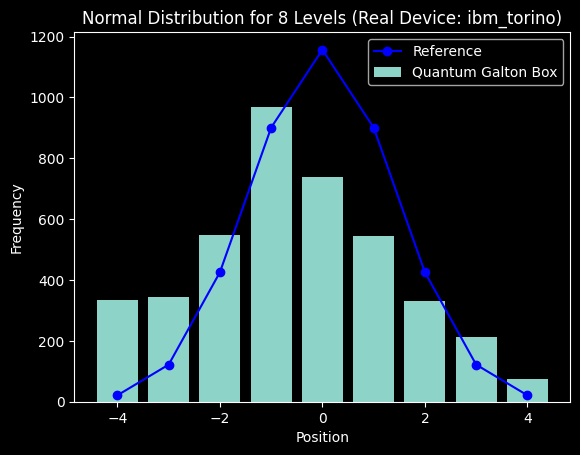

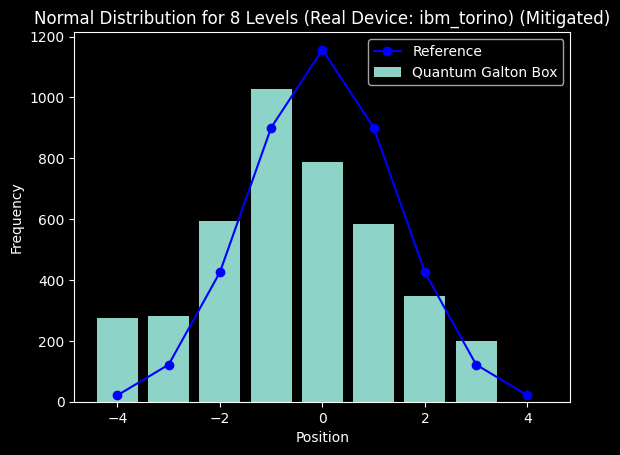

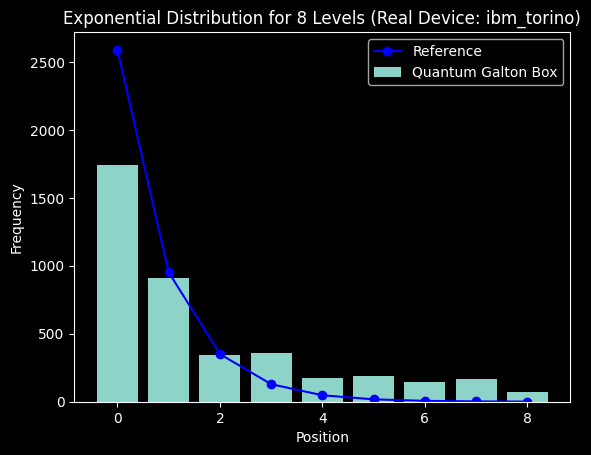

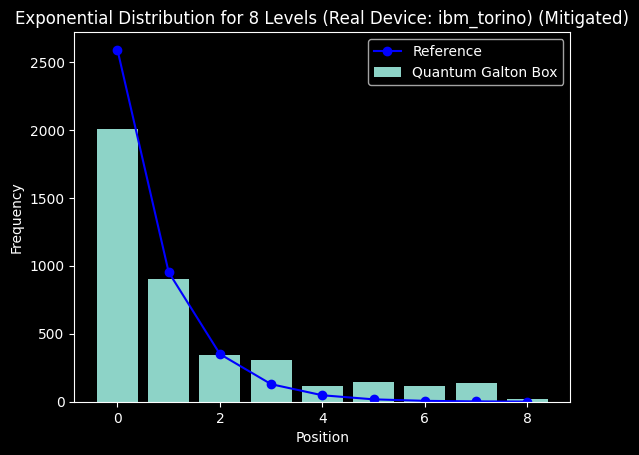

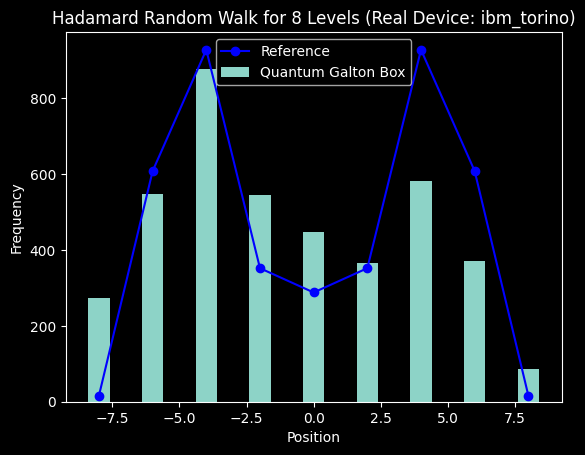

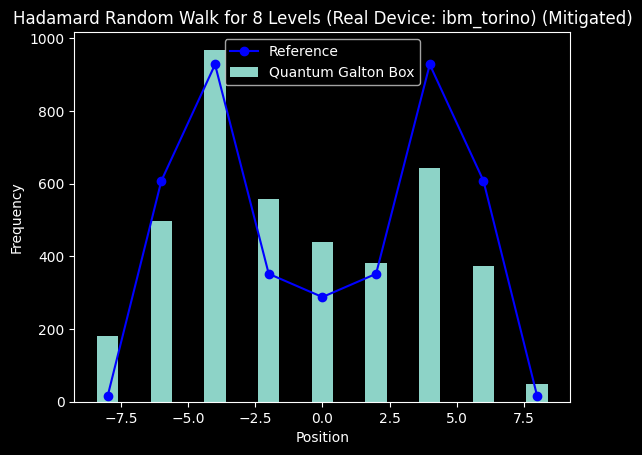

In [34]:
if ENABLE_REAL_DEVICE:
    n = 8
    circuit_defs = [
        CircuitDefinition(
            circuit_generator=create_opt_qgb_circuit,
            coin=optimized_coin,
            distribution_type=DistributionType.NORMAL,
            title=f"Normal Distribution for {n} Levels (Real Device: {real_torino.name})",
        ),
        CircuitDefinition(
            circuit_generator=create_opt_qgb_circuit,
            coin=optimized_coin,
            distribution_type=DistributionType.EXPONENTIAL,
            title=f"Exponential Distribution for {n} Levels (Real Device: {real_torino.name})",
        ),
        CircuitDefinition(
            circuit_generator=create_opt_qgb_circuit,
            coin=optimized_coin,
            distribution_type=DistributionType.HADAMARD,
            title=f"Hadamard Random Walk for {n} Levels (Real Device: {real_torino.name})",
        ),
    ]
    _ = run_optimized_multi_job_simulation(
        circuit_defs,
        n,
        SHOTS,
        RunMode.REAL_DEVICE,
        backend=real_torino,
        mitigate_noise=True,
        plots=True,
    )

We can recognize the shapes of each distribution though the distances from reference are quite large. Noise mitigation with M3 package had little effect.

With that, it is quite an impressive performance by the IBM Torino backend! 🎉🎉🎉